# OWL tutorial

Let's install owlrl if we do not have it

In [ ]:
## Uncomment if you do not have owlrl installed (you should have it installed from the RDFS tutorial)
import sys
!{sys.executable} -m pip install rdflib owlrl Owlready2

from rdflib import Graph, Literal, Namespace, RDF, URIRef, OWL
from rdflib.namespace import DC, FOAF

from owlready2 import *

# documentation : https://pythonhosted.org/Owlready2/

Let's start with some basic information from a .CSV

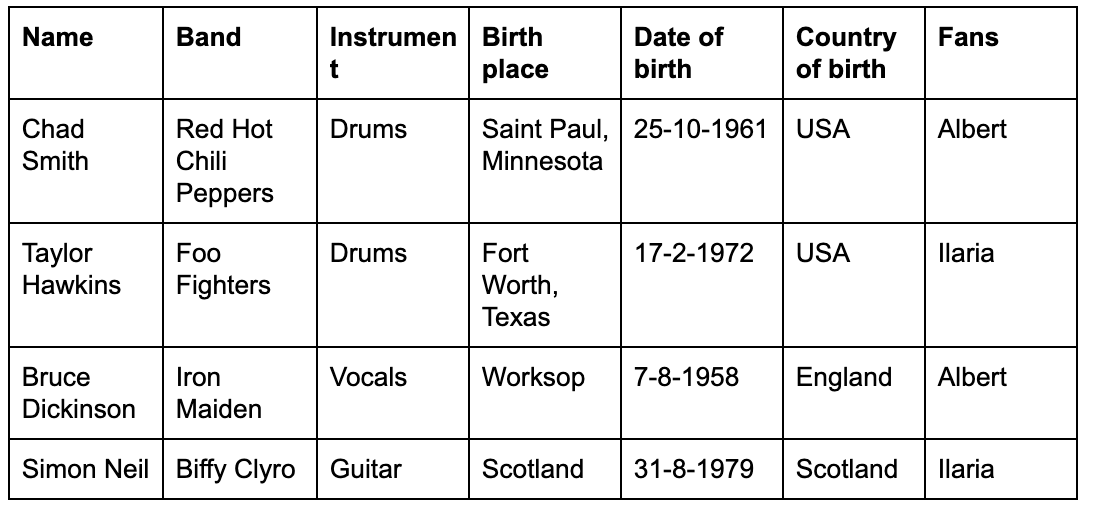

Initialise an empty ontology

In [ ]:
onto = get_ontology("http://test.org/myonto.owl") # creates an empty ontology. Use the namespace you like!

Initialise an empty ontology

In [ ]:
# classes
class Person(Thing):
    namespace = onto
    
class Band(Thing):
    namespace = onto
        
class Instrument(Thing):
    namespace = onto

class Location(Thing) :
    namespace = onto
        
#class Country(Thing):
#    namespace = onto

In [ ]:
# add a class that is a subclass      
class Artist(Person):
    namespace = onto
    
print(Artist.ancestors())

In [ ]:
# print the list of the classes in the ontology

print(list(onto.classes()))

#### Create object properties
Properties of type owl:ObjectProperty have only non-literals as range, 
They are rdfs:subPropertyOf owl:topObjectProperty

In [ ]:
class plays_instrument(ObjectProperty): 
    domain = [Artist]
    range = [Instrument]
    namespace = onto
    pass
        
class has_fan(ObjectProperty, Artist >> Person) : # another way of specifying domain and range
    namespace = onto

class born_in(Person >> Location ):
    namespace = onto

class has_artist(ObjectProperty, Band >> Artist): 
    namespace = onto

Let's add properties with restrictions too

In [ ]:
# properties with restrictions
class located_in(ObjectProperty, TransitiveProperty): # if <A locatedin B>, and <B locatedin C>, infer <A locatedin C> 
    namespace = onto
    domain = [Location]
    range = [Location]
    
class plays_in(ObjectProperty, Artist >> Band): 
    inverse_property =  has_artist # if <A plays_in B>, infer <B hasArtist A>
    namespace = onto
    
class is_fan(Person >> Artist): 
    inverse_property = has_fan 
    namespace = onto
    
class plays_with(ObjectProperty, SymmetricProperty): #  if <A plays_with B>, infer <B plays_with A>
    domain = [Artist]
    range = [Artist]   
    namespace = onto

#### Create datatype properties
Properties of type owl:DatatypeProperty have only literals as range,
They are rdfs:subPropertyOf owl:topDatatypeProperty

In [ ]:
# datatype properties 
class birth_date(DataProperty, FunctionalProperty): #every Person has only one birth date
    namespace = onto
    domain = [Person]
    range = [str] # we will use strings for the time being
        
class age(DataProperty, FunctionalProperty):
    namespace = onto
    domain = [Person]
    range = [int] 

In [ ]:
#print all properties
list(onto.properties()) # can also return .object_properties() or .data_properties()

### Adding class restrictions 
Class Restictions are special owl:Classes

In [ ]:
Band.is_a.append(has_artist.min(2,Artist)) # restriction over Band : a band must have minimum 2 artists
#Band.is_a.append(has_artist.only(Artist))

Artist.is_a.append(plays_instrument.min(1))


# restrictions can also be specified in a class definition directly
class Fan(Person): 
    namespace=onto
    equivalent_to = [ Person & is_fan.some(Artist)]  

class SoloArtist(Artist): 
    namespace=onto
    equivalent_to = [ Artist & Not(plays_in.some(Band))]

    
class MusicPerformer(Thing): 
    namespace=onto
    equivalent_to = [ Band | SoloArtist ]  
    

AllDisjoint([Band,SoloArtist]) # in this world, you cannot be a Band and a SoloArtist at the same time 


#### Create instances (individuals)
Instances in OWL are called individuals!

In [ ]:
biffy = Band("biffy_clyro")
simon = Artist("simon_neil", namespace = onto ) # you can also add a namespace

# creating individuals with properties 
james = Artist("james_johnston", namespace = onto, plays_with=[simon] )
ilaria = Person("ilaria", namespace = onto, is_fan=[simon], birth_date="19-03-1997" ) # because I am 23 yo
    
# or adding a property to an individual directly
simon.plays_in = [biffy]
    
uk = Location('united_kingdom', namespace= onto)
scotland = Location("Scotland", namespace= onto, located_in = [uk])
edi = Location("Edinburgh", namespace= onto, located_in = [scotland])
    
print("Simon's IRI : %s" % simon.iri)
print("Ilaria is born on %s" % ilaria.birth_date)



In [ ]:
# searching instances 
print("Who plays with someone? \n%s"% onto.search(plays_with = "*"))

print("Search for a IRI containing 'ilaria'\n%s" % onto.search(iri = "*ilaria"))

print("Which artist has a fan?\n%s" % onto.search(type=onto.Artist, has_fan="*"))

    
## other Basic queries
# iri, for searching entities by its full IRI
# type, for searching Individuals of a given Class
# subclass_of, for searching subclasses of a given Class
# is_a*, for searching both Individuals and subclasses of a given Class

In [ ]:
guitar     = Instrument('guitar')
piano    = Instrument('piano')
vocals = Instrument('vocals')

# Assert that there is only three possible instruments in this world
Instrument.is_a.append(OneOf([guitar, piano, vocals]))

#and that all instruments are different (instance level)
AllDifferent([guitar, piano, vocals])

Let's look at disjointness in our ontology

In [ ]:
for d in onto.disjoints(): # will print both AllDifferent (individuals) and AllDisjoint (classes)
    print(d.entities)

### Inference time
Now let's do some inference

In [ ]:
print("Simon has fan : %s" % simon.has_fan) # did we specify that simon has any fan?
print("Simon plays with : %s" % simon.plays_with) # did we specify who simon plays with?

In [ ]:
# NB : we never assert that simon and james were persons!
for p in Person.instances(): # all people :
    print(p)


for i in Instrument.instances(): # all instruments :
    print(i)
    

In [ ]:
# transitive property
print("Edinburgh is located in : %s" % edi.located_in) # does not work :(

#### Save ontology
Let's save it in an .owl file

In [ ]:
onto.save(file = "my_first_owl_ontology.owl", format = "rdfxml") # also supported ntriples